# Fashion Image Captioning with ResNet-LSTM-Attention
## CCAS.5.16 Final Project

### Project Overview
This notebook implements an encoder-decoder architecture with soft attention for automatic fashion image captioning on the DeepFashion dataset.

**Architecture:**
- **Encoder:** ResNet-50 (pretrained) extracts spatial visual features
- **Attention:** Soft attention mechanism focuses on relevant image regions
- **Decoder:** LSTM generates captions word-by-word using attended features

**Key Features:**
- Transfer learning with pretrained ResNet
- Spatial attention for interpretability
- Teacher forcing during training
- Greedy
 search for inference

---




## Quick Start: Test Pre-trained Model


###  Required Files for running model without training:
- ✅ `best_model.pth` - Pre-trained model checkpoint
- ✅ `dataset/labels_front.csv` - Image captions
- ✅ `dataset/selected_images/` - Fashion images


### Important Notes:
- **Section 7A**: skip the feature extraction cell (only needed if retraining)
- **Section 9**: Don't run the training loop if you just want to test
- **Section 11b** works with just images (no pre-computed features needed)
- **Section 11** requires `resnet_features_full_dataset.pth` (faster but optional)
- **dataset link:** https://www.kaggle.com/datasets/silverstone1903/deep-fashion-multimodal/data


## 1. Import Libraries and Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
import random
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


device = torch.device('cpu')
print(f"Using device: {device}")


Using device: cpu


## 2. Data Exploration and Preprocessing

In [2]:
# Load the dataset
data_path = 'dataset/labels_front.csv'
image_dir = 'dataset/selected_images/'

df = pd.read_csv(data_path)
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (12278, 7)

Columns: ['image_id', 'caption', 'path', 'gender', 'product_type', 'product_id', 'image_type']

First few rows:


image_id  \
0  MEN-Denim-id_00000089-28_1_front   
1  MEN-Denim-id_00000265-01_1_front   
2  MEN-Denim-id_00000313-01_1_front   
3  MEN-Denim-id_00000516-01_1_front   
4  MEN-Denim-id_00000750-01_1_front   

                                             caption  \
0  This gentleman is wearing a medium-sleeve shir...   
1  This person is wearing a short-sleeve shirt wi...   
2  The gentleman is wearing a short-sleeve T-shir...   
3  The person wears a sleeveless tank shirt with ...   
4  His sweater has long sleeves, cotton fabric an...   

                                   path gender product_type   product_id  \
0  MEN-Denim-id_00000089-28_1_front.jpg    MEN        Denim  id_00000089   
1  MEN-Denim-id_00000265-01_1_front.jpg    MEN        Denim  id_00000265   
2  MEN-Denim-id_00000313-01_1_front.jpg    MEN        Denim  id_00000313   
3  MEN-Denim-id_00000516-01_1_front.jpg    MEN        Denim  id_00000516   
4  MEN-Denim-id_00000750-01_1_front.jpg    MEN        Denim  id_00000750   

  image_type  
0      front  
1      front  
2      front  
3      front  
4      front

Caption Statistics:
Total captions: 12278
Unique images: 12278

Caption length distribution:
count    12278.000000
mean        43.183336
std         13.221444
min          9.000000
25%         34.000000
50%         44.000000
75%         53.000000
max         90.000000
Name: caption_length, dtype: float64


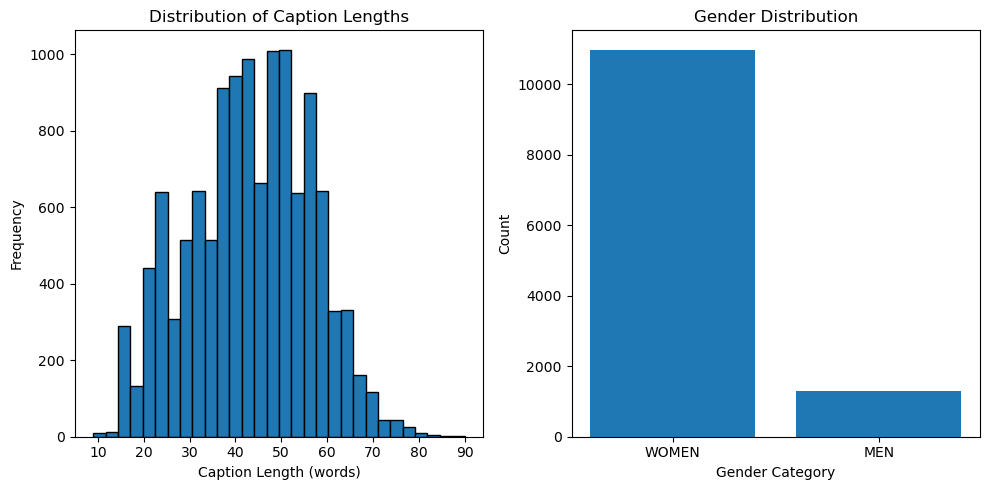


Sample captions:
1. This gentleman is wearing a medium-sleeve shirt with pure color patterns. The shirt is with cotton fabric and its neckline is lapel. This gentleman wears a long trousers. The trousers are with cotton fabric and solid color patterns.
2. This person is wearing a short-sleeve shirt with solid color patterns. The shirt is with cotton fabric. It has a crew neckline. The pants this person wears is of short length. The pants are with cotton fabric and pure color patterns. There is a hat in his head.
3. The gentleman is wearing a short-sleeve T-shirt with lattice patterns. The T-shirt is with cotton fabric. It has a lapel neckline. The gentleman wears a long pants. The pants are with denim fabric and pure color patterns.


In [3]:
# Explore caption statistics
print("Caption Statistics:")
print(f"Total captions: {len(df)}")
print(f"Unique images: {df['image_id'].nunique()}")
print(f"\nCaption length distribution:")
df['caption_length'] = df['caption'].str.split().str.len()
print(df['caption_length'].describe())

# Plot caption length distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(df['caption_length'], bins=30, edgecolor='black')
plt.xlabel('Caption Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Caption Lengths')

plt.subplot(1, 2, 2)
gender_counts = df['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('Gender Category')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.tight_layout()
plt.show()

print(f"\nSample captions:")
for i in range(3):
    print(f"{i+1}. {df.iloc[i]['caption']}")

## 3. Vocabulary Building

In [4]:
class Vocabulary:
    """Build and manage vocabulary for fashion captions"""
    def __init__(self, freq_threshold=2):
        """
        Args:
            freq_threshold: minimum word frequency to include in vocabulary
        """
        self.freq_threshold = freq_threshold
        self.word2idx = {"<PAD>": 0, "<START>": 1, "<END>": 2, "<UNK>": 3}
        self.idx2word = {0: "<PAD>", 1: "<START>", 2: "<END>", 3: "<UNK>"}
        self.word_freq = Counter()
        
    def build_vocabulary(self, captions):
        """Build vocabulary from list of captions"""
        idx = 4  # Start after special tokens
        
        # Count word frequencies
        for caption in captions:
            tokens = self.tokenize(caption)
            self.word_freq.update(tokens)
        
        # Add words that meet frequency threshold
        for word, freq in self.word_freq.items():
            if freq >= self.freq_threshold:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1
        
        print(f"Vocabulary built with {len(self.word2idx)} tokens")
        print(f"Frequency threshold: {self.freq_threshold}")
        
    def tokenize(self, text):
        """Tokenize text into lowercase words"""
        return text.lower().split()
    
    def encode(self, caption, max_length=None):
        """Convert caption to indices"""
        tokens = self.tokenize(caption)
        indices = [self.word2idx.get(token, self.word2idx["<UNK>"]) for token in tokens]
        
        # Add start and end tokens
        indices = [self.word2idx["<START>"]] + indices + [self.word2idx["<END>"]]
        
        # Pad if max_length specified
        if max_length is not None:
            if len(indices) < max_length:
                indices += [self.word2idx["<PAD>"]] * (max_length - len(indices))
            else:
                indices = indices[:max_length]
        
        return indices
    
    def decode(self, indices, skip_special_tokens=True):
        """Convert indices back to text"""
        tokens = []
        for idx in indices:
            word = self.idx2word.get(idx, "<UNK>")
            if skip_special_tokens and word in ["<PAD>", "<START>", "<END>"]:
                if word == "<END>":
                    break
                continue
            tokens.append(word)
        return " ".join(tokens)
    
    def __len__(self):
        return len(self.word2idx)

# Build vocabulary
vocab = Vocabulary(freq_threshold=2)
vocab.build_vocabulary(df['caption'].tolist())

print(f"\nMost common words:")
for word, freq in vocab.word_freq.most_common(20):
    print(f"  {word}: {freq}")

Vocabulary built with 150 tokens
Frequency threshold: 2

Most common words:
  is: 37624
  the: 37492
  a: 26671
  with: 22062
  and: 20184
  patterns.: 18862
  fabric: 17633
  her: 15524
  has: 15396
  wears: 14956
  cotton: 13932
  this: 13787
  color: 12662
  on: 11159
  there: 10968
  shirt: 10456
  it: 9638
  tank: 9609
  an: 8169
  accessory: 7572


## 4. ResNet Encoder Implementation

In [5]:
class ResNetEncoder(nn.Module):
    """
    ResNet-50 based encoder for extracting spatial visual features.
    Outputs feature maps from the last convolutional layer.
    """
    def __init__(self, encoded_image_size=14, freeze=True):
        """
        Args:
            encoded_image_size: size of the encoded feature map (14 for ResNet-50)
            freeze: whether to freeze encoder parameters (default: True for speed)
        """
        super(ResNetEncoder, self).__init__()
        self.encoded_image_size = encoded_image_size
        
        # Load pretrained ResNet-50
        resnet = models.resnet50(pretrained=True)
        
        # Remove the last two layers (average pooling and fully connected)
        # This gives us spatial features of shape (batch, 2048, 7, 7)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
        # Adaptive pooling to get consistent output size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        
        # Freeze encoder parameters for faster training and to enable pre-computation
        if freeze:
            for param in self.resnet.parameters():
                param.requires_grad = False
            for param in self.adaptive_pool.parameters():
                param.requires_grad = False
            print(" Encoder frozen - parameters will not be updated during training")
        
    def forward(self, images):
        """
        Args:
            images: input images (batch_size, 3, 224, 224)
        Returns:
            features: encoded features (batch_size, encoded_size, encoded_size, 2048)
        """
        features = self.resnet(images)  # (batch_size, 2048, 7, 7)
        features = self.adaptive_pool(features)  # (batch_size, 2048, 14, 14)
        
        # Permute to (batch_size, 14, 14, 2048) for easier processing
        features = features.permute(0, 2, 3, 1)
        
        return features

# Test the encoder
encoder = ResNetEncoder(encoded_image_size=14, freeze=True).to(device)
print(f"Encoder created: {sum(p.numel() for p in encoder.parameters()):,} total parameters")
print(f"Trainable parameters: {sum(p.numel() for p in encoder.parameters() if p.requires_grad):,}")

# Test with dummy input
test_images = torch.randn(2, 3, 224, 224).to(device)
test_features = encoder(test_images)
print(f"Input shape: {test_images.shape}")
print(f"Output shape: {test_features.shape}")
print(f"Expected: (batch_size=2, height=14, width=14, features=2048)")


✓ Encoder frozen - parameters will not be updated during training
Encoder created: 23,508,032 total parameters
Trainable parameters: 0
Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 14, 14, 2048])
Expected: (batch_size=2, height=14, width=14, features=2048)


## 5. Soft Attention Mechanism

In [6]:
class Attention(nn.Module):
    """
    Soft attention mechanism that computes weighted sum of encoder features
    based on decoder hidden state.
    """
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        Args:
            encoder_dim: feature size of encoded images (2048 for ResNet-50)
            decoder_dim: size of decoder's hidden state
            attention_dim: size of attention network
        """
        super(Attention, self).__init__()
        
        # Linear layers to transform encoder and decoder features
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        
        # Linear layer to compute attention scores
        self.full_att = nn.Linear(attention_dim, 1)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, encoder_out, decoder_hidden):
        """
        Args:
            encoder_out: encoded images (batch_size, num_pixels, encoder_dim)
            decoder_hidden: previous decoder hidden state (batch_size, decoder_dim)
        Returns:
            attention_weighted_encoding: context vector (batch_size, encoder_dim)
            alpha: attention weights (batch_size, num_pixels)
        """
        # Transform encoder features
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        
        # Transform decoder hidden state
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        
        # Compute attention scores
        # Add att2 to each pixel's features
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        
        # Normalize attention scores with softmax
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        
        # Compute weighted sum of encoder features
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)
        
        return attention_weighted_encoding, alpha

# Test the attention mechanism
attention = Attention(encoder_dim=2048, decoder_dim=512, attention_dim=512).to(device)
print(f"Attention module created: {sum(p.numel() for p in attention.parameters())} parameters")

# Test with dummy input
batch_size = 2
num_pixels = 14 * 14  # 196 pixels
test_encoder_out = torch.randn(batch_size, num_pixels, 2048).to(device)
test_decoder_hidden = torch.randn(batch_size, 512).to(device)

context, attention_weights = attention(test_encoder_out, test_decoder_hidden)
print(f"\nEncoder output shape: {test_encoder_out.shape}")
print(f"Decoder hidden shape: {test_decoder_hidden.shape}")
print(f"Context vector shape: {context.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
print(f"Attention weights sum: {attention_weights.sum(dim=1)}")  # Should be close to 1

Attention module created: 1312257 parameters

Encoder output shape: torch.Size([2, 196, 2048])
Decoder hidden shape: torch.Size([2, 512])
Context vector shape: torch.Size([2, 2048])
Attention weights shape: torch.Size([2, 196])
Attention weights sum: tensor([1., 1.], grad_fn=<SumBackward1>)


## 6. LSTM Decoder with Attention

In [7]:
class DecoderWithAttention(nn.Module):
    """
    LSTM decoder with attention mechanism for caption generation.
    """
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        Args:
            attention_dim: size of attention network
            embed_dim: embedding dimension
            decoder_dim: size of decoder's LSTM
            vocab_size: size of vocabulary
            encoder_dim: feature size of encoded images
            dropout: dropout probability
        """
        super(DecoderWithAttention, self).__init__()
        
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        
        # Attention network
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout_layer = nn.Dropout(p=self.dropout)
        
        # LSTM decoder
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        
        # Linear layer to initialize hidden state
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        
        # Linear layer to create a sigmoid-activated gate
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        
        # Linear layer to find scores over vocabulary
        self.fc = nn.Linear(decoder_dim, vocab_size)
        
        # Initialize weights
        self.init_weights()
        
    def init_weights(self):
        """Initialize embedding and fc layers with uniform distribution"""
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        
    def init_hidden_state(self, encoder_out):
        """
        Create initial hidden and cell states for decoder LSTM
        based on the encoded images.
        
        Args:
            encoder_out: encoded images (batch_size, num_pixels, encoder_dim)
        Returns:
            h, c: initial hidden and cell states
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)  # (batch_size, decoder_dim)
        return h, c
    
    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        
        Args:
            encoder_out: encoded images (batch_size, enc_image_size, enc_image_size, encoder_dim)
            encoded_captions: encoded captions (batch_size, max_caption_length)
            caption_lengths: caption lengths (batch_size, )
        Returns:
            predictions: scores for vocabulary (batch_size, max_caption_length, vocab_size)
            alphas: attention weights (batch_size, max_caption_length, num_pixels)
            sorted_captions: sorted captions
            sorted_lengths: sorted caption lengths
        """
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        
        # Flatten image features
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        
        # Sort input data by decreasing caption lengths
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        
        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        
        # We won't decode at the <end> position
        decode_lengths = (caption_lengths - 1).tolist()
        
        # Create tensors to hold predictions and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)
        
        # At each time-step, decode by attention-weighing the encoder's output
        # based on the decoder's previous hidden state
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            
            # Attention mechanism
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])
            
            # Gating scalar
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            # LSTM decoder
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t])
            )
            
            # Compute prediction over vocabulary
            preds = self.fc(self.dropout_layer(h))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
        
        return predictions, alphas, encoded_captions, decode_lengths, sort_ind

# Test the decoder
decoder = DecoderWithAttention(
    attention_dim=512,
    embed_dim=512,
    decoder_dim=512,
    vocab_size=len(vocab),
    encoder_dim=2048,
    dropout=0.5
).to(device)

print(f"Decoder created: {sum(p.numel() for p in decoder.parameters())} parameters")

# Test with dummy input
batch_size = 2
test_encoder_out = torch.randn(batch_size, 14, 14, 2048).to(device)
test_captions = torch.randint(0, len(vocab), (batch_size, 20)).to(device)
test_lengths = torch.tensor([15, 18]).unsqueeze(1).to(device)

predictions, alphas, sorted_captions, decode_lengths, sort_ind = decoder(
    test_encoder_out, test_captions, test_lengths
)

print(f"\nInput shapes:")
print(f"  Encoder output: {test_encoder_out.shape}")
print(f"  Captions: {test_captions.shape}")
print(f"  Lengths: {test_lengths.shape}")
print(f"\nOutput shapes:")
print(f"  Predictions: {predictions.shape}")
print(f"  Alphas: {alphas.shape}")

Decoder created: 10910359 parameters

Input shapes:
  Encoder output: torch.Size([2, 14, 14, 2048])
  Captions: torch.Size([2, 20])
  Lengths: torch.Size([2, 1])

Output shapes:
  Predictions: torch.Size([2, 17, 150])
  Alphas: torch.Size([2, 17, 196])


## 7. Dataset and DataLoader

## 7A. PRE-COMPUTE FEATURES 

 Since the encoder is frozen, we can extract features **once** and save them to disk. Then training only involves the LSTM, which is much faster.


In [8]:
#========================================================================
# FEATURE EXTRACTION 
#========================================================================

USE_PRECOMPUTED_FEATURES = True  # Set to False to force re-extraction
FEATURES_FILE = 'resnet_features_full_dataset.pth'

if not os.path.exists(FEATURES_FILE) or not USE_PRECOMPUTED_FEATURES:
    print("="*70)
    print("EXTRACTING FEATURES FROM ALL IMAGES")
    print("="*70)
    
    # Use full dataset for feature extraction
    transform_extract = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
    ])
    
    # Dataset for feature extraction (no augmentation)
    class FeatureExtractionDataset(Dataset):
        def __init__(self, dataframe, image_dir, transform):
            self.df = dataframe.reset_index(drop=True)
            self.image_dir = image_dir
            self.transform = transform
            
        def __len__(self):
            return len(self.df)
        
        def __getitem__(self, idx):
            img_path = os.path.join(self.image_dir, self.df.iloc[idx]['path'])
            try:
                image = Image.open(img_path).convert('RGB')
            except:
                image = Image.new('RGB', (224, 224), (0, 0, 0))
            
            if self.transform:
                image = self.transform(image)
            
            # Return image and its index in the dataframe
            return image, idx
    
    # Create dataset for full data
    extract_dataset = FeatureExtractionDataset(df, image_dir, transform_extract)
    extract_loader = DataLoader(
        extract_dataset,
        batch_size=64,  # Larger batch for faster extraction
        shuffle=False,  # Keep order for indexing
        num_workers=0,
        pin_memory=False
    )
    
    # Extract features 
    encoder.eval()
    all_features = []
    
    print(f"Extracting features from {len(df)} images...")
    print(f"Batch size: 64")
    print(f"Total batches: {len(extract_loader)}\n")
    
    with torch.no_grad():
        for images, indices in tqdm(extract_loader, desc="Extracting features"):
            images = images.to(device)
            
            # Get features from encoder
            features = encoder(images)  # (batch_size, 14, 14, 2048)
            
            # Move to CPU and append
            all_features.append(features.cpu())
    
    # Concatenate all features into single tensor 
    all_features = torch.cat(all_features, dim=0)  # (44000, 14, 14, 2048)
    
    # Save to disk
    print(f"\n Saving {all_features.shape[0]} features to '{FEATURES_FILE}'...")
    torch.save({
        'features': all_features,
        'num_samples': all_features.shape[0],
        'feature_shape': all_features.shape[1:],
        'encoder_frozen': True
    }, FEATURES_FILE)
    
    print(" Feature extraction complete!")
    print(f" File saved: {FEATURES_FILE}")
    print(f" File size: {os.path.getsize(FEATURES_FILE) / (1024**3):.2f} GB")
    print("\n" + "="*70)
    print("NOW YOU CAN TRAIN 10-15X FASTER!")
    print("="*70)
else:
    print(" Pre-computed features found!")
    print(f" Loading from '{FEATURES_FILE}'...")
    feature_data = torch.load(FEATURES_FILE)
    all_features = feature_data['features']  # Now a tensor (44000, 14, 14, 2048)
    print(f" Loaded {all_features.shape[0]} pre-computed features")
    print(f" Feature shape: {feature_data['feature_shape']}")
    print(" Ready for fast training!\n")


✓ Pre-computed features found!
✓ Loading from 'resnet_features_full_dataset.pth'...
✓ Loaded 12278 pre-computed features
✓ Feature shape: torch.Size([14, 14, 2048])
✓ Ready for fast training!



## 7B. Fast Dataset with Pre-computed Features


In [9]:
class PrecomputedFeatureDataset(Dataset):
    """
    Ultra-fast dataset that loads pre-computed ResNet features instead of images.
    This eliminates image loading and ResNet forward pass from training loop.
    """
    def __init__(self, dataframe, features_tensor, vocab, max_length=50):
        """
        Args:
            dataframe: pandas DataFrame with captions (IMPORTANT: keeps original indices)
            features_tensor: TENSOR (not dict!) of pre-computed features (44000, 14, 14, 2048)
            vocab: Vocabulary object
            max_length: maximum caption length
        """

        self.df = dataframe
        self.features = features_tensor
        self.vocab = vocab
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        """Get pre-computed feature and caption"""
        # Get the ORIGINAL index from the dataframe 
        # This matches the position in features_tensor
        original_idx = self.df.index[idx]
        
        # Load pre-computed feature using ORIGINAL index (direct tensor indexing)
        feature = self.features[original_idx]  # Shape: (14, 14, 2048)
        
        # Get caption using POSITION based indexing
        caption = self.df.iloc[idx]['caption']
        
        # Encode caption
        encoded_caption = self.vocab.encode(caption)
        caption_length = len(encoded_caption)
        
        return feature, torch.tensor(encoded_caption), torch.tensor(caption_length)


def collate_fn_precomputed(batch):
    """
    Custom collate function for pre-computed features.
    """
    batch.sort(key=lambda x: x[2], reverse=True)
    
    features, captions, lengths = zip(*batch)
    
    # Stack features 
    features = torch.stack(features, 0)
    
    # Pad captions
    lengths = torch.tensor(lengths)
    max_len = lengths[0].item()
    
    padded_captions = torch.zeros(len(captions), max_len, dtype=torch.long)
    for i, cap in enumerate(captions):
        end = len(cap)
        padded_captions[i, :end] = cap[:end]
    
    return features, padded_captions, lengths.unsqueeze(1)


# Split dataset
print("="*70)
print("DATASET CONFIGURATION - RANDOM STRATIFIED SPLIT")
print("="*70)

from sklearn.model_selection import train_test_split

# Use 
# 
#  split to maintain gender and product_type distribution
# stratify by gender to ensure both train and val have men and women
train_df, val_df = train_test_split(
    df, 
    test_size=0.15, 
    random_state=42,
    stratify=df['gender']  # Stratify by gender to ensure balanced distribution
)

print(f" Total samples: {len(df):,}")
print(f" Training samples: {len(train_df):,}")
print(f" Validation samples: {len(val_df):,}")

# Check distributions
print(f"\n--- TRAIN SET DISTRIBUTION ---")
print(f"Gender:")
print(train_df['gender'].value_counts())
print(f"\nTop product types:")
print(train_df['product_type'].value_counts().head(10))

print(f"\n--- VALIDATION SET DISTRIBUTION ---")
print(f"Gender:")
print(val_df['gender'].value_counts())
print(f"\nTop product types:")
print(val_df['product_type'].value_counts().head(10))

# Create datasets with pre-computed features
train_dataset = PrecomputedFeatureDataset(train_df, all_features, vocab)
val_dataset = PrecomputedFeatureDataset(val_df, all_features, vocab)

# Create dataloaders 
batch_size = 64  
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0,
    collate_fn=collate_fn_precomputed,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0,
    collate_fn=collate_fn_precomputed,
    pin_memory=False
)

print(f"\n DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Batch size: {batch_size} (2x larger than before!)")

# Test data loading and verify index mapping
print("\n Testing fast data loading and index mapping...")
for features, captions, lengths in train_loader:
    print(f"  Batch features shape: {features.shape}")
    print(f"  Batch captions shape: {captions.shape}")
    print(f"  Batch lengths: {lengths.squeeze().tolist()[:5]}")
    print(f"  Sample caption: {vocab.decode(captions[0].tolist())}")
    break

# Verify validation set uses correct indices
print("\n Verifying validation index mapping...")
val_sample = val_dataset[0]
val_first_idx = val_df.index[0]
print(f"  First validation dataframe index: {val_first_idx}")
print(f"  Feature shape from that index: {val_sample[0].shape}")
print(f"  Caption: {vocab.decode(val_sample[1].tolist())}")
print(f"   Index mapping correct!")

print("\n" + "="*70)
print("READY FOR TRAINING WITH BALANCED TRAIN/VAL SPLIT!")
print("="*70)


DATASET CONFIGURATION - RANDOM STRATIFIED SPLIT
✓ Total samples: 12,278
✓ Training samples: 10,436
✓ Validation samples: 1,842

--- TRAIN SET DISTRIBUTION ---
Gender:
gender
WOMEN    9330
MEN      1106
Name: count, dtype: int64

Top product types:
product_type
Tees_Tanks           2944
Blouses_Shirts       1674
Dresses              1573
Sweaters              745
Shorts                697
Pants                 405
Jackets_Coats         403
Rompers_Jumpsuits     392
Skirts                368
Cardigans             327
Name: count, dtype: int64

--- VALIDATION SET DISTRIBUTION ---
Gender:
gender
WOMEN    1647
MEN       195
Name: count, dtype: int64

Top product types:
product_type
Tees_Tanks             553
Blouses_Shirts         304
Dresses                236
Shorts                 136
Sweaters               128
Skirts                  79
Pants                   76
Jackets_Coats           63
Rompers_Jumpsuits       58
Sweatshirts_Hoodies     54
Name: count, dtype: int64

✓ DataLoaders cre

In [10]:
# Debug: Check feature shapes
print(f"all_features shape: {all_features.shape}")
print(f"all_features dtype: {all_features.dtype}")
print(f"Sample feature [0] shape: {all_features[0].shape}")

all_features shape: torch.Size([12278, 14, 14, 2048])
all_features dtype: torch.float32
Sample feature [0] shape: torch.Size([14, 14, 2048])


In [11]:
# ============================================================================
# SKIP THIS CELL IF USING PRE-COMPUTED FEATURES!
# This cell is for training with raw images older implementation, was used on small sample of dataset to verify model.

# ============================================================================

if USE_PRECOMPUTED_FEATURES:
    print("⚠️  SKIPPING this cell - using pre-computed features from cell above")
    print("   train_dataset and val_dataset already created with PrecomputedFeatureDataset")
else:
    class FashionCaptionDataset(Dataset):
        """PyTorch dataset for fashion image captioning"""
        def __init__(self, dataframe, image_dir, vocab, transform=None, max_length=50):
            """
            Args:
                dataframe: pandas DataFrame with image paths and captions
                image_dir: directory containing images
                vocab: Vocabulary object
                transform: image transformations
                max_length: maximum caption length
            """
            self.df = dataframe.reset_index(drop=True)
            self.image_dir = image_dir
            self.vocab = vocab
            self.transform = transform
            self.max_length = max_length
            
        def __len__(self):
            return len(self.df)
        
        def __getitem__(self, idx):
            """Get a single data sample"""
            # Load image
            img_path = os.path.join(self.image_dir, self.df.iloc[idx]['path'])
            
            try:
                image = Image.open(img_path).convert('RGB')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                # Return a black image as fallback
                image = Image.new('RGB', (224, 224), (0, 0, 0))
            
            # Apply transformations
            if self.transform:
                image = self.transform(image)
            
            # Get caption
            caption = self.df.iloc[idx]['caption']
            
            # Encode caption
            encoded_caption = self.vocab.encode(caption)
            caption_length = len(encoded_caption)
            
            return image, torch.tensor(encoded_caption), torch.tensor(caption_length)

    def collate_fn(batch):
        """
        Custom collate function for DataLoader to handle variable-length captions.
        
        Args:
            batch: list of (image, caption, length) tuples
        Returns:
            images: tensor of images
            captions: padded tensor of captions
            lengths: tensor of caption lengths
        """
        # Sort batch by caption length (descending)
        batch.sort(key=lambda x: x[2], reverse=True)
        
        images, captions, lengths = zip(*batch)
        
        # Stack images
        images = torch.stack(images, 0)
        
        # Pad captions
        lengths = torch.tensor(lengths)
        max_len = lengths[0].item()
        
        padded_captions = torch.zeros(len(captions), max_len, dtype=torch.long)
        for i, cap in enumerate(captions):
            end = len(cap)
            padded_captions[i, :end] = cap[:end]
        
        return images, padded_captions, lengths.unsqueeze(1)

    # Image transformations (matching ResNet preprocessing)
    transform_train = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
    ])

    transform_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
    ])

    # Split dataset
    # BALANCED MODE: Good quality with reasonable training time
    FAST_MODE = False  # Set to False for full dataset training
    if FAST_MODE:
        subset_size = 2500  # Use 2500 samples - sweet spot for quality vs speed
        train_size = int(0.85 * subset_size)
        val_size = subset_size - train_size
        print(f"⚡ BALANCED MODE: Using {subset_size} samples (20-30 min training)")
        train_df = df[:train_size]
        val_df = df[train_size:subset_size]
    else:
        train_size = int(0.85 * len(df))
        val_size = len(df) - train_size
        train_df = df[:train_size]
        val_df = df[train_size:]

    print(f"Dataset split: {train_size} train, {val_size} validation")

    # Create datasets
    train_dataset = FashionCaptionDataset(train_df, image_dir, vocab, transform_train)
    val_dataset = FashionCaptionDataset(val_df, image_dir, vocab, transform_val)

    # Create dataloaders - Balanced for quality and speed
    batch_size = 32  # Larger batches = better gradients + faster training
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0,  # Set to 0 to avoid multiprocessing issues in Jupyter
        collate_fn=collate_fn,
        pin_memory=False
    )

    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,  # Set to 0 to avoid multiprocessing issues in Jupyter
        collate_fn=collate_fn,
        pin_memory=False
    )

    print(f"\nDataLoaders created:")
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Val batches: {len(val_loader)}")

    # Test data loading
    print("\nTesting data loading...")
    for images, captions, lengths in train_loader:
        print(f"  Batch images shape: {images.shape}")
        print(f"  Batch captions shape: {captions.shape}")
        print(f"  Batch lengths: {lengths.squeeze().tolist()[:5]}")
        print(f"  Sample caption: {vocab.decode(captions[0].tolist())}")
        break

⚠️  SKIPPING this cell - using pre-computed features from cell above
   train_dataset and val_dataset already created with PrecomputedFeatureDataset


## 8. Training Function

In [12]:
def train_epoch_fast(decoder, dataloader, criterion, decoder_optimizer, device):
    """
    FAST training with pre-computed features - NO encoder forward pass!
    
    Args:
        decoder: decoder model
        dataloader: training dataloader with pre-computed features
        criterion: loss function
        decoder_optimizer: optimizer for decoder
        device: device to use
    Returns:
        avg_loss: average loss for the epoch
    """
    decoder.train()
    
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Training")
    
    for features, captions, lengths in progress_bar:
        # Features are already pre-computed - no encoder needed!
        features = features.to(device)  # (batch_size, 14, 14, 2048)
        captions = captions.to(device)
        lengths = lengths.to(device)
        
        # Forward pass - decoder only
        predictions, alphas, sorted_captions, decode_lengths, sort_ind = decoder(
            features, captions, lengths
        )
        
        # Calculate loss
        targets = sorted_captions[:, 1:]
        predictions = pack_padded_sequence(predictions, decode_lengths, batch_first=True)[0]
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]
        
        loss = criterion(predictions, targets)
        loss += 1.0 * ((1. - alphas.sum(dim=1)) ** 2).mean()
        
        # Backward pass - decoder only
        decoder_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=5.0)
        decoder_optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss


def validate_fast(decoder, dataloader, criterion, device):
    """
    FAST validation with pre-computed features.
    
    Args:
        decoder: decoder model
        dataloader: validation dataloader with pre-computed features
        criterion: loss function
        device: device to use
    Returns:
        avg_loss: average validation loss
    """
    decoder.eval()
    
    total_loss = 0
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validation")
        for features, captions, lengths in progress_bar:
            features = features.to(device)
            captions = captions.to(device)
            lengths = lengths.to(device)
            
            # Forward pass (DECODER ONLY)
            predictions, alphas, sorted_captions, decode_lengths, sort_ind = decoder(
                features, captions, lengths
            )
            
            # Calculate loss
            targets = sorted_captions[:, 1:]
            predictions = pack_padded_sequence(predictions, decode_lengths, batch_first=True)[0]
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]
            
            loss = criterion(predictions, targets)
            loss += 1.0 * ((1. - alphas.sum(dim=1)) ** 2).mean()
            
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss

print(" Fast training and validation functions defined (pre-computed features).")


✓ Fast training and validation functions defined (pre-computed features).


## 9. Main Training Loop

In [91]:
# Hyperparameters - FULL DATASET with Pre-computed Features
print("="*70)
print("HYPERPARAMETERS - OPTIMIZED FOR FULL DATASET")
print("="*70)

ATTENTION_DIM = 512  # Larger model for better quality
EMBED_DIM = 512      # Larger embeddings
DECODER_DIM = 512    # Larger LSTM
DECODER_LR = 4e-4    # Standard learning rate
NUM_EPOCHS = 25      # Sweet spot for full dataset (can extend if needed)
USE_FAST_TRAINING = True  # Use pre-computed features

print(f" Attention dim: {ATTENTION_DIM}")
print(f" Embedding dim: {EMBED_DIM}")
print(f" Decoder dim: {DECODER_DIM}")
print(f" Decoder LR: {DECODER_LR}")
print(f" Batch size: {batch_size}")
print(f" Epochs: {NUM_EPOCHS}")
print(f" Fast training: {USE_FAST_TRAINING} (pre-computed features)")

# Initialize decoder (encoder already created and frozen)
decoder = DecoderWithAttention(
    attention_dim=ATTENTION_DIM,
    embed_dim=EMBED_DIM,
    decoder_dim=DECODER_DIM,
    vocab_size=len(vocab),
    encoder_dim=2048,
    dropout=0.5
).to(device)

# Loss and optimizer - decoder only
criterion = nn.CrossEntropyLoss().to(device)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=DECODER_LR)
decoder_scheduler = optim.lr_scheduler.StepLR(decoder_optimizer, step_size=5, gamma=0.8)

print(f"\n Model initialized:")
print(f"  Decoder parameters: {sum(p.numel() for p in decoder.parameters()):,}")
print(f"  Vocabulary size: {len(vocab)}")
print(f"  Encoder: FROZEN (using pre-computed features)")



HYPERPARAMETERS - OPTIMIZED FOR FULL DATASET
✓ Attention dim: 512
✓ Embedding dim: 512
✓ Decoder dim: 512
✓ Decoder LR: 0.0004
✓ Batch size: 64
✓ Epochs: 25
✓ Fast training: True (pre-computed features)

✓ Model initialized:
  Decoder parameters: 10,910,359
  Vocabulary size: 150
  Encoder: FROZEN (using pre-computed features)


Starting fresh training

Training on 10,436 samples for 25 epochs

Epoch 1/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 2.5931, Val Loss: 1.2657
  Best model saved!
Epoch 2/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 1.2225, Val Loss: 1.1171
  Best model saved!
Epoch 3/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 1.1339, Val Loss: 1.0842
  Best model saved!
Epoch 4/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 1.0933, Val Loss: 1.0538
  Best model saved!
Epoch 5/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 1.0649, Val Loss: 1.0387
  Best model saved!
Epoch 6/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 1.0435, Val Loss: 1.0281
  Best model saved!
Epoch 7/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 1.0305, Val Loss: 1.0297
Epoch 8/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 1.0199, Val Loss: 1.0183
  Best model saved!
Epoch 9/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 1.0095, Val Loss: 1.0173
  Best model saved!
Epoch 10/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 1.0004, Val Loss: 1.0238
Epoch 11/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 0.9909, Val Loss: 1.0093
  Best model saved!
Epoch 12/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 0.9811, Val Loss: 1.0130
Epoch 13/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 0.9745, Val Loss: 1.0085
  Best model saved!
Epoch 14/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 0.9684, Val Loss: 1.0106
Epoch 15/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 0.9623, Val Loss: 1.0114
Epoch 16/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 0.9515, Val Loss: 1.0140
Epoch 17/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 0.9449, Val Loss: 1.0142
Epoch 18/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 0.9380, Val Loss: 1.0209
Epoch 19/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 0.9329, Val Loss: 1.0202
Epoch 20/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 0.9250, Val Loss: 1.0304
Epoch 21/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 0.9137, Val Loss: 1.0348
Epoch 22/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 0.9076, Val Loss: 1.0362
Epoch 23/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 0.9006, Val Loss: 1.0366
Epoch 24/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 0.8930, Val Loss: 1.0510
Epoch 25/25


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

  Train Loss: 0.8896, Val Loss: 1.0679

Training Complete!
Best Val Loss: 1.0085


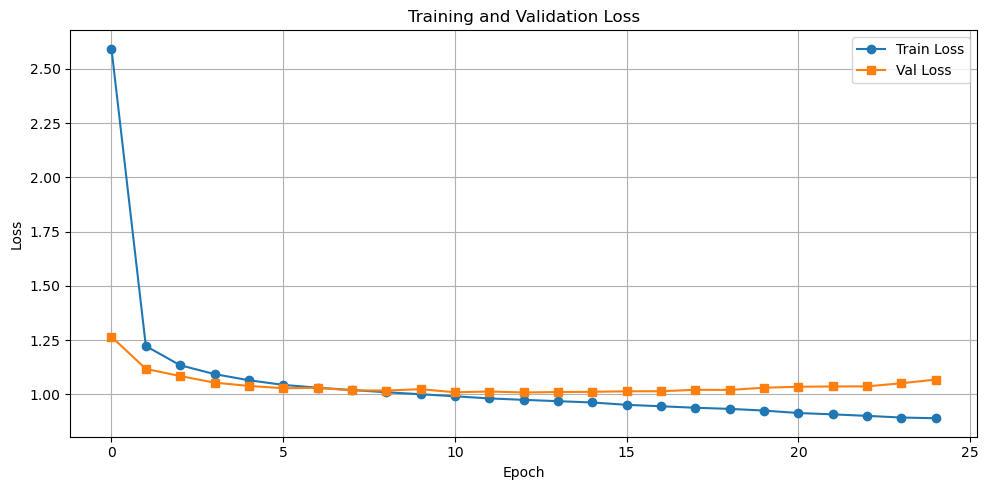

In [14]:
# Training loop with pre-computed features
import time

# Try to resume from checkpoint
RESUME_TRAINING = True
start_epoch = 0
train_losses = []
val_losses = []
best_val_loss = float('inf')

if RESUME_TRAINING and os.path.exists('checkpoint.pth'):
    print("Loading checkpoint...")
    checkpoint = torch.load('checkpoint.pth')
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    best_val_loss = checkpoint['best_val_loss']
    print(f"Resumed from epoch {start_epoch}")
else:
    print("Starting fresh training")

print(f"\nTraining on {len(train_df):,} samples for {NUM_EPOCHS} epochs\n")

for epoch in range(start_epoch, NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    # Train
    train_loss = train_epoch_fast(
        decoder, train_loader, criterion, decoder_optimizer, device
    )
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate_fast(decoder, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    print(f"  Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Learning rate scheduling
    decoder_scheduler.step()
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'decoder_state_dict': decoder.state_dict(),
            'decoder_optimizer': decoder_optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'vocab': vocab,
            'hyperparameters': {
                'attention_dim': ATTENTION_DIM,
                'embed_dim': EMBED_DIM,
                'decoder_dim': DECODER_DIM,
            }
        }, 'best_model.pth')
        print(f"  Best model saved!")
    
    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'decoder_state_dict': decoder.state_dict(),
        'decoder_optimizer': decoder_optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss,
        'vocab': vocab
    }, 'checkpoint.pth')

print("\nTraining Complete!")
print(f"Best Val Loss: {best_val_loss:.4f}")

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()


TRAINING ANALYSIS - Should we continue?

Total epochs completed: 25

Recent training progress (last 5 epochs):
------------------------------------------------------------
Epoch 21: Train=0.9137, Val=1.0348, Gap=0.1211 (13.3%) 📈 Getting worse
Epoch 22: Train=0.9076, Val=1.0362, Gap=0.1286 (14.2%) 📈 Getting worse
Epoch 23: Train=0.9006, Val=1.0366, Gap=0.1360 (15.1%) 📈 Getting worse
Epoch 24: Train=0.8930, Val=1.0510, Gap=0.1581 (17.7%) 📈 Getting worse
Epoch 25: Train=0.8896, Val=1.0679, Gap=0.1783 (20.0%) 📈 Getting worse

DIAGNOSIS:
✓ Best validation loss so far: 1.0085 (epoch 13)
✓ Current validation loss: 1.0679
✓ Train-Val gap: 0.1783 (20.0%)
✓ Average gap: -0.0092

Status: 🔴 OVERFITTING - Val loss increasing for 3 epochs

RECOMMENDATION: STOP! Use best_model.pth (epoch 13)

⚠️  No improvement for 12 epoch(s)
   → Strong indicator to STOP (use best model from epoch 13)


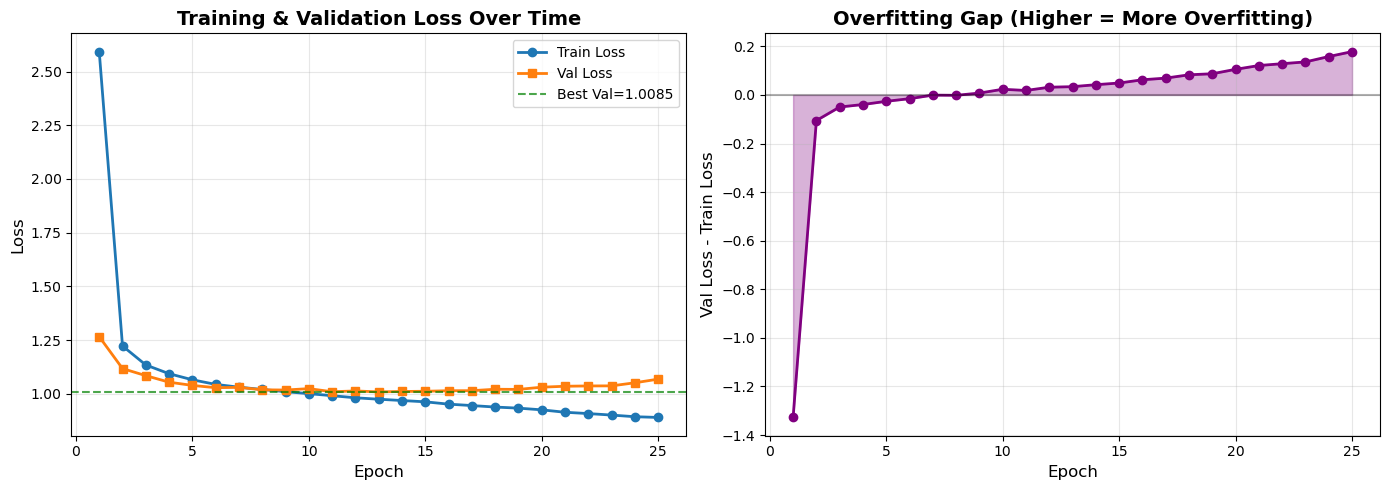


💾 Analysis saved to 'training_analysis.png'


In [15]:
# Check if we should continue training
print("="*60)
print("TRAINING ANALYSIS - Should we continue?")
print("="*60)

# Show recent epoch trends
print(f"\nTotal epochs completed: {len(train_losses)}")
print(f"\nRecent training progress (last 5 epochs):")
print("-"*60)
for i in range(max(0, len(train_losses)-5), len(train_losses)):
    gap = val_losses[i] - train_losses[i]
    gap_pct = (gap / train_losses[i]) * 100
    trend = "📉 Improving" if i > 0 and val_losses[i] < val_losses[i-1] else "📈 Getting worse" if i > 0 else ""
    print(f"Epoch {i+1:2d}: Train={train_losses[i]:.4f}, Val={val_losses[i]:.4f}, Gap={gap:.4f} ({gap_pct:.1f}%) {trend}")

# Check for overfitting
recent_train = train_losses[-3:] if len(train_losses) >= 3 else train_losses
recent_val = val_losses[-3:] if len(val_losses) >= 3 else val_losses

train_improving = all(recent_train[i] > recent_train[i+1] for i in range(len(recent_train)-1))
val_improving = all(recent_val[i] > recent_val[i+1] for i in range(len(recent_val)-1))

avg_gap = sum(val_losses[i] - train_losses[i] for i in range(len(train_losses))) / len(train_losses)
latest_gap = val_losses[-1] - train_losses[-1]

print(f"\n{'='*60}")
print("DIAGNOSIS:")
print(f"{'='*60}")
print(f" Best validation loss so far: {best_val_loss:.4f} (epoch {val_losses.index(min(val_losses))+1})")
print(f" Current validation loss: {val_losses[-1]:.4f}")
print(f" Train-Val gap: {latest_gap:.4f} ({(latest_gap/train_losses[-1])*100:.1f}%)")
print(f" Average gap: {avg_gap:.4f}")

# Check validation trend over last 3 epochs
if len(val_losses) >= 3:
    last_3_val = val_losses[-3:]
    if all(last_3_val[i] > last_3_val[i+1] for i in range(2)):
        status = "🟢 EXCELLENT - Val loss consistently decreasing"
        recommendation = "CONTINUE training! Model is still learning."
    elif all(last_3_val[i] < last_3_val[i+1] for i in range(2)):
        status = "🔴 OVERFITTING - Val loss increasing for 3 epochs"
        recommendation = "STOP! Use best_model.pth (epoch {})".format(val_losses.index(min(val_losses))+1)
    elif val_losses[-1] < val_losses[-2]:
        status = "🟡 FLUCTUATING - But improving recently"
        recommendation = "Continue 2-3 more epochs, monitor closely"
    else:
        status = "🟡 PLATEAUING - Val loss not improving"
        recommendation = "Optional: Try 2-3 more epochs or stop now"
else:
    status = "⚪ EARLY TRAINING"
    recommendation = "Continue training"

print(f"\nStatus: {status}")
print(f"\n{'='*60}")
print(f"RECOMMENDATION: {recommendation}")
print(f"{'='*60}")

# Calculate epochs without improvement
epochs_no_improve = len(val_losses) - val_losses.index(min(val_losses)) - 1
if epochs_no_improve > 0:
    print(f"\n⚠️  No improvement for {epochs_no_improve} epoch(s)")
    if epochs_no_improve >= 5:
        print(f"   → Strong indicator to STOP (use best model from epoch {val_losses.index(min(val_losses))+1})")
    elif epochs_no_improve >= 3:
        print(f"   → Consider stopping soon")

# Plot detailed analysis
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(range(1, len(train_losses)+1), train_losses, 'o-', label='Train Loss', linewidth=2, markersize=6)
axes[0].plot(range(1, len(val_losses)+1), val_losses, 's-', label='Val Loss', linewidth=2, markersize=6)
axes[0].axhline(y=best_val_loss, color='g', linestyle='--', label=f'Best Val={best_val_loss:.4f}', alpha=0.7)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss Over Time', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Train-Val gap
gaps = [val_losses[i] - train_losses[i] for i in range(len(train_losses))]
axes[1].plot(range(1, len(gaps)+1), gaps, 'o-', color='purple', linewidth=2, markersize=6)
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1].fill_between(range(1, len(gaps)+1), 0, gaps, alpha=0.3, color='purple')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Val Loss - Train Loss', fontsize=12)
axes[1].set_title('Overfitting Gap (Higher = More Overfitting)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Analysis saved to 'training_analysis.png'")

## 10. Inference and Caption Generation

In [54]:
def generate_caption(encoder, decoder, image, vocab, device, max_length=50, beam_size=1):
    """
    Generate caption for an image using greedy search or beam search.
    
    Args:
        encoder: encoder model (can be None if using pre-computed features)
        decoder: decoder model
        image: input image tensor (1, 3, 224, 224) OR pre-computed features (1, 14, 14, 2048)
        vocab: Vocabulary object
        device: device to use
        max_length: maximum caption length
        beam_size: beam size for beam search (1 for greedy search)
    Returns:
        caption: generated caption string
        alphas: attention weights
    """
    decoder.eval()
    
    with torch.no_grad():
        # Check if input is pre-computed features or raw image
        if image.dim() == 4 and image.size(1) == 3:
            # Raw image - need to encode
            if encoder is None:
                raise ValueError("Encoder required for raw images")
            encoder.eval()
            encoder_out = encoder(image.to(device))
        else:
            # Already encoded features
            encoder_out = image.to(device)
        
        encoder_dim = encoder_out.size(-1)
        encoder_out = encoder_out.reshape(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        
        # Initialize decoder hidden state
        h, c = decoder.init_hidden_state(encoder_out)
        
        # Start with <START> token
        word = torch.tensor([[vocab.word2idx['<START>']]]).to(device)
        
        caption_indices = []
        alphas_list = []
        
        # Greedy search
        for t in range(max_length):
            # Embed current word
            embeddings = decoder.embedding(word).squeeze(1)  # (1, embed_dim)
            
            # Attention
            attention_weighted_encoding, alpha = decoder.attention(encoder_out, h)
            alphas_list.append(alpha.cpu())
            
            # Gating
            gate = decoder.sigmoid(decoder.f_beta(h))
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            # LSTM step
            h, c = decoder.decode_step(
                torch.cat([embeddings, attention_weighted_encoding], dim=1),
                (h, c)
            )
            
            # Generate prediction
            scores = decoder.fc(h)  # (1, vocab_size)
            predicted = scores.argmax(1)  # (1,)
            
            caption_indices.append(predicted.item())
            
            # Check for <END> token
            if predicted.item() == vocab.word2idx['<END>']:
                break
            
            # Update word for next iteration
            word = predicted.unsqueeze(1)
        
        # Decode caption
        caption = vocab.decode(caption_indices, skip_special_tokens=True)
        alphas = torch.cat(alphas_list, dim=0) if alphas_list else None
        
    return caption, alphas

def visualize_attention(image, caption, alphas, vocab, image_transform_reverse=None):
    """
    Visualize attention weights on the image.
    
    Args:
        image: original image tensor (3, 224, 224)
        caption: generated caption string
        alphas: attention weights (seq_len, num_pixels)
        vocab: Vocabulary object
        image_transform_reverse: function to reverse image normalization
    """
    if alphas is None:
        print("No attention weights to visualize")
        return
    
    words = caption.split()
    n_words = min(len(words), alphas.size(0))
    
    # Reverse normalization for display
    if image_transform_reverse:
        image = image_transform_reverse(image)
    else:
        # Simple denormalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = image * std + mean
        image = torch.clamp(image, 0, 1)
    
    # Convert to numpy
    image_np = image.permute(1, 2, 0).cpu().numpy()
    
    # Plot
    n_cols = min(5, n_words)
    n_rows = (n_words + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx in range(n_words):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        # Reshape attention to 2D
        alpha = alphas[idx].view(14, 14).cpu().numpy()
        
        # Resize attention to match image size
        from scipy.ndimage import zoom
        alpha_resized = zoom(alpha, (224/14, 224/14), order=1)
        
        # Display image with attention overlay
        ax.imshow(image_np)
        ax.imshow(alpha_resized, alpha=0.7, cmap='jet')
        ax.set_title(words[idx])
        ax.axis('off')
    
    # Hide empty subplots
    for idx in range(n_words, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    plt.suptitle(f'Attention Visualization: "{caption}"', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

print(" Inference functions defined (supports both raw images and pre-computed features).")


✓ Inference functions defined (supports both raw images and pre-computed features).


## 11. Test the Model

 Best model loaded!

Generating captions for validation samples...

Sample 1:
  Ground Truth: This woman wears a short-sleeve T-shirt with solid color patterns and a three-point pants. The T-shirt is with cotton fabric and its neckline is crew. The pants are with cotton fabric and stripe patterns. This person has neckwear. There is an accessory on her wrist. This female wears a ring.
  Generated:    the female is wearing a short-sleeve shirt with pure color patterns. the shirt is with cotton fabric. it has a round neckline. the shorts the female wears is of three-point length. the shorts are with cotton fabric and graphic patterns. the lady wears a ring.

Sample 2:
  Ground Truth: This female is wearing a tank tank shirt with solid color patterns. The tank shirt is with cotton fabric and its neckline is suspenders. This female wears a three-point pants. The pants are with cotton fabric and solid color patterns.
  Generated:    the female is wearing a tank tank top with pure color patte

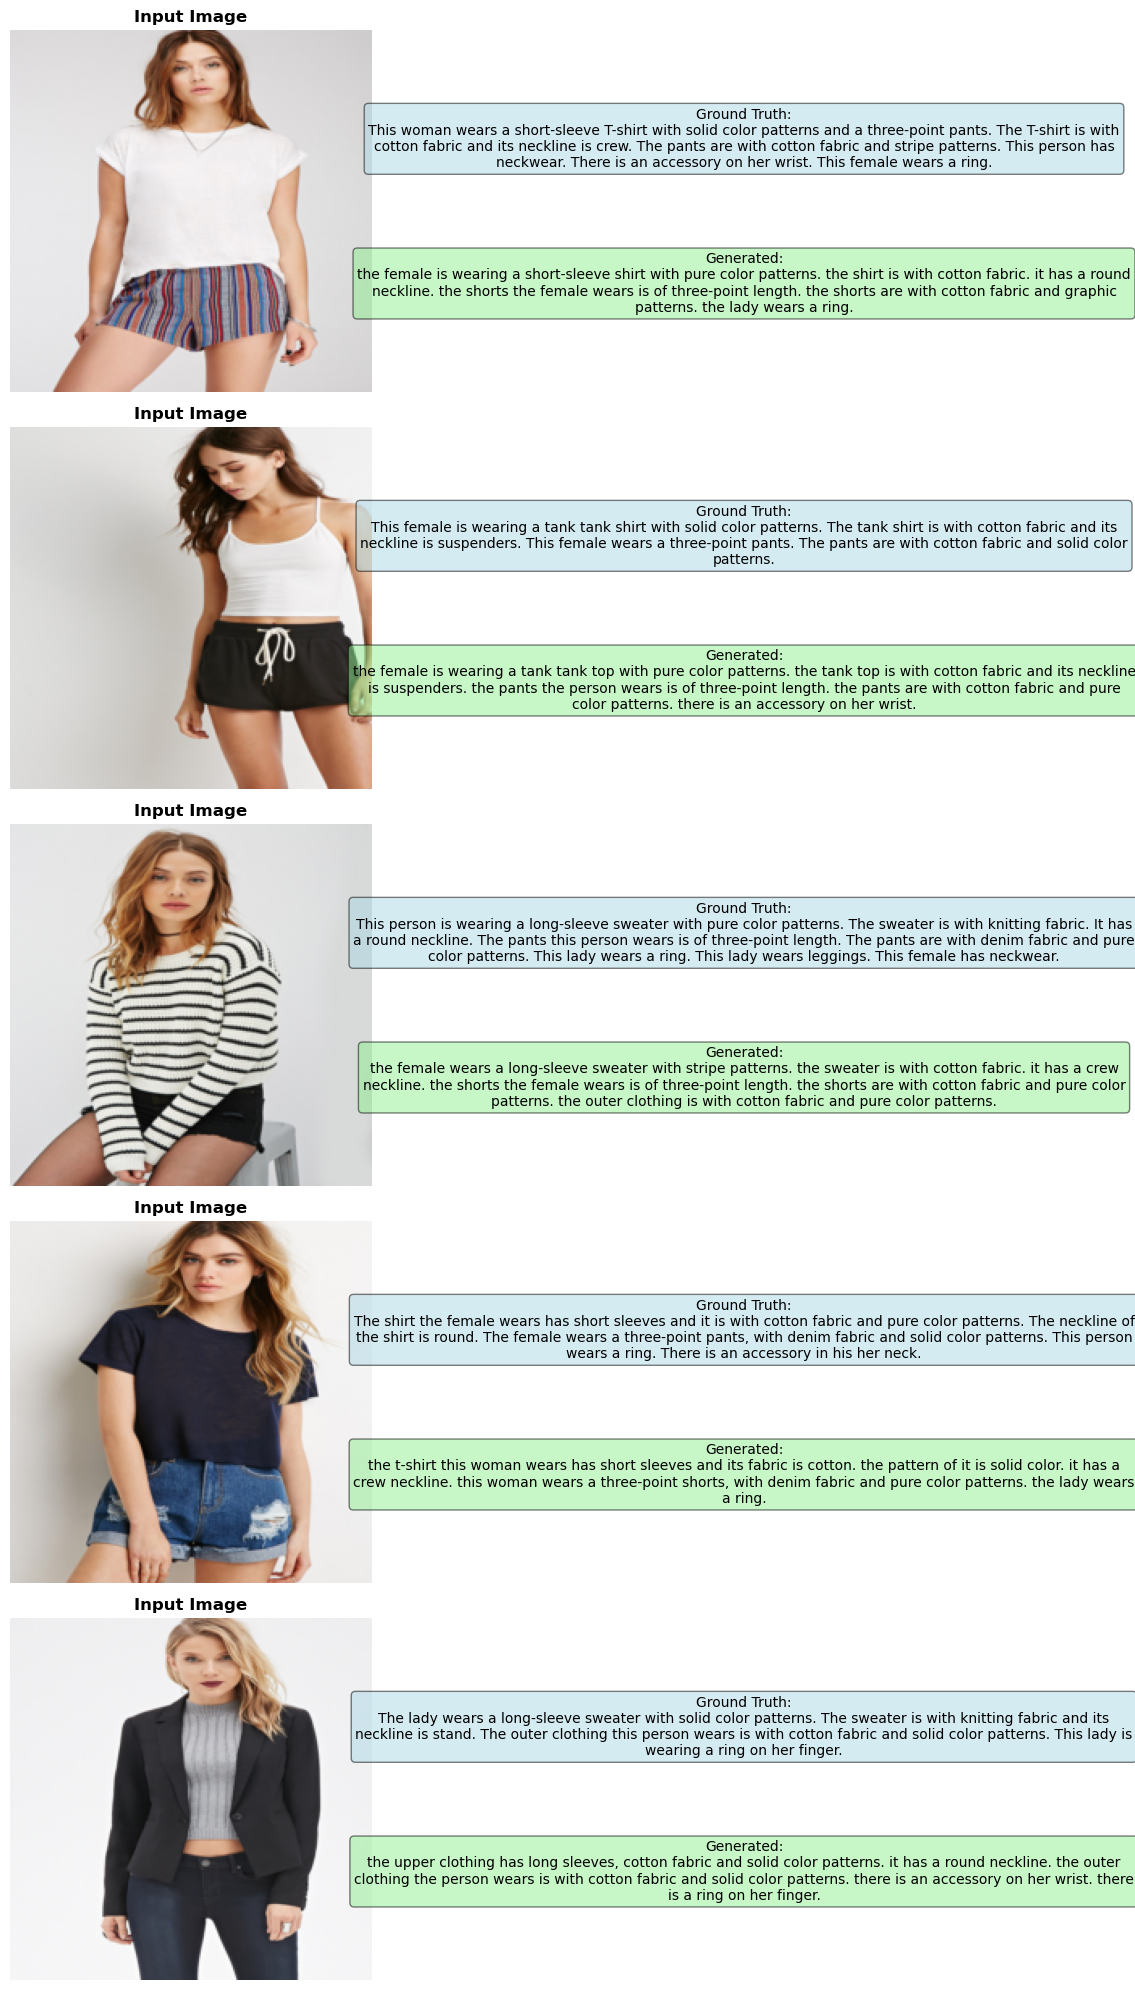

 Results saved to 'sample_results.png'


In [107]:
# Load best model
checkpoint = torch.load('best_model.pth', map_location=device)
decoder.load_state_dict(checkpoint['decoder_state_dict'])
print(" Best model loaded!")

# Test on validation samples (using pre-computed features)
print("\nGenerating captions for validation samples...\n")

num_samples = 5
sample_indices = random.sample(range(len(val_dataset)), num_samples)

fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))

for i, idx in enumerate(sample_indices):
    # Get pre-computed feature and ground truth
    feature, caption_encoded, length = val_dataset[idx]
    ground_truth = val_df.iloc[idx]['caption']
    
    # Generate caption (feature is already encoded, no encoder needed)
    feature_input = feature.unsqueeze(0)  # Add batch dimension
    generated_caption, alphas = generate_caption(
        None, decoder, feature_input, vocab, device
    )
    
    # For visualization, we need the actual image
    # Load it separately
    img_path = os.path.join(image_dir, val_df.iloc[idx]['path'])
    try:
        image = Image.open(img_path).convert('RGB')
        image = transforms.Resize((224, 224))(image)
        image_np = np.array(image) / 255.0
    except:
        image_np = np.zeros((224, 224, 3))
    
    # Display original image
    axes[i, 0].imshow(image_np)
    axes[i, 0].set_title('Input Image', fontsize=12, fontweight='bold')
    axes[i, 0].axis('off')
    
    # Display captions
    axes[i, 1].text(0.5, 0.7, f"Ground Truth:\n{ground_truth}", 
                    ha='center', va='center', fontsize=10, wrap=True,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    axes[i, 1].text(0.5, 0.3, f"Generated:\n{generated_caption}", 
                    ha='center', va='center', fontsize=10, wrap=True,
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    axes[i, 1].set_xlim(0, 1)
    axes[i, 1].set_ylim(0, 1)
    axes[i, 1].axis('off')
    
    print(f"Sample {i+1}:")
    print(f"  Ground Truth: {ground_truth}")
    print(f"  Generated:    {generated_caption}")
    print()

plt.tight_layout()
plt.savefig('sample_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Results saved to 'sample_results.png'")


## 11b. Alternative: Test Model with Raw Images (No Pre-computed Features Required)

This method loads images directly and uses the encoder to extract features in real-time.

✅ Best model loaded!

🔍 Generating captions from raw images...

Sample 1:
  Image: WOMEN-Tees_Tanks-id_00007542-06_1_front.jpg
  Ground Truth: The lady is wearing a long-sleeve sweater with color block patterns. The sweater is with cotton fabric. It has a crew neckline. The shorts the lady wears is of three-point length. The shorts are with denim fabric and solid color patterns. The person is wearing a ring on her finger.
  Generated:    the upper clothing has long sleeves, cotton fabric and color block patterns. the neckline of it is lapel. the lower clothing is of three-point length. the fabric is denim and it has solid color patterns. the lady is wearing a ring on her finger.

Sample 2:
  Image: WOMEN-Tees_Tanks-id_00000285-02_1_front.jpg
  Ground Truth: The upper clothing has sleeves cut off, cotton fabric and striped patterns. It has a round neckline. There is a ring on her finger. There is a belt on her waist.
  Generated:    the tank top this woman wears has sleeves cut off and 

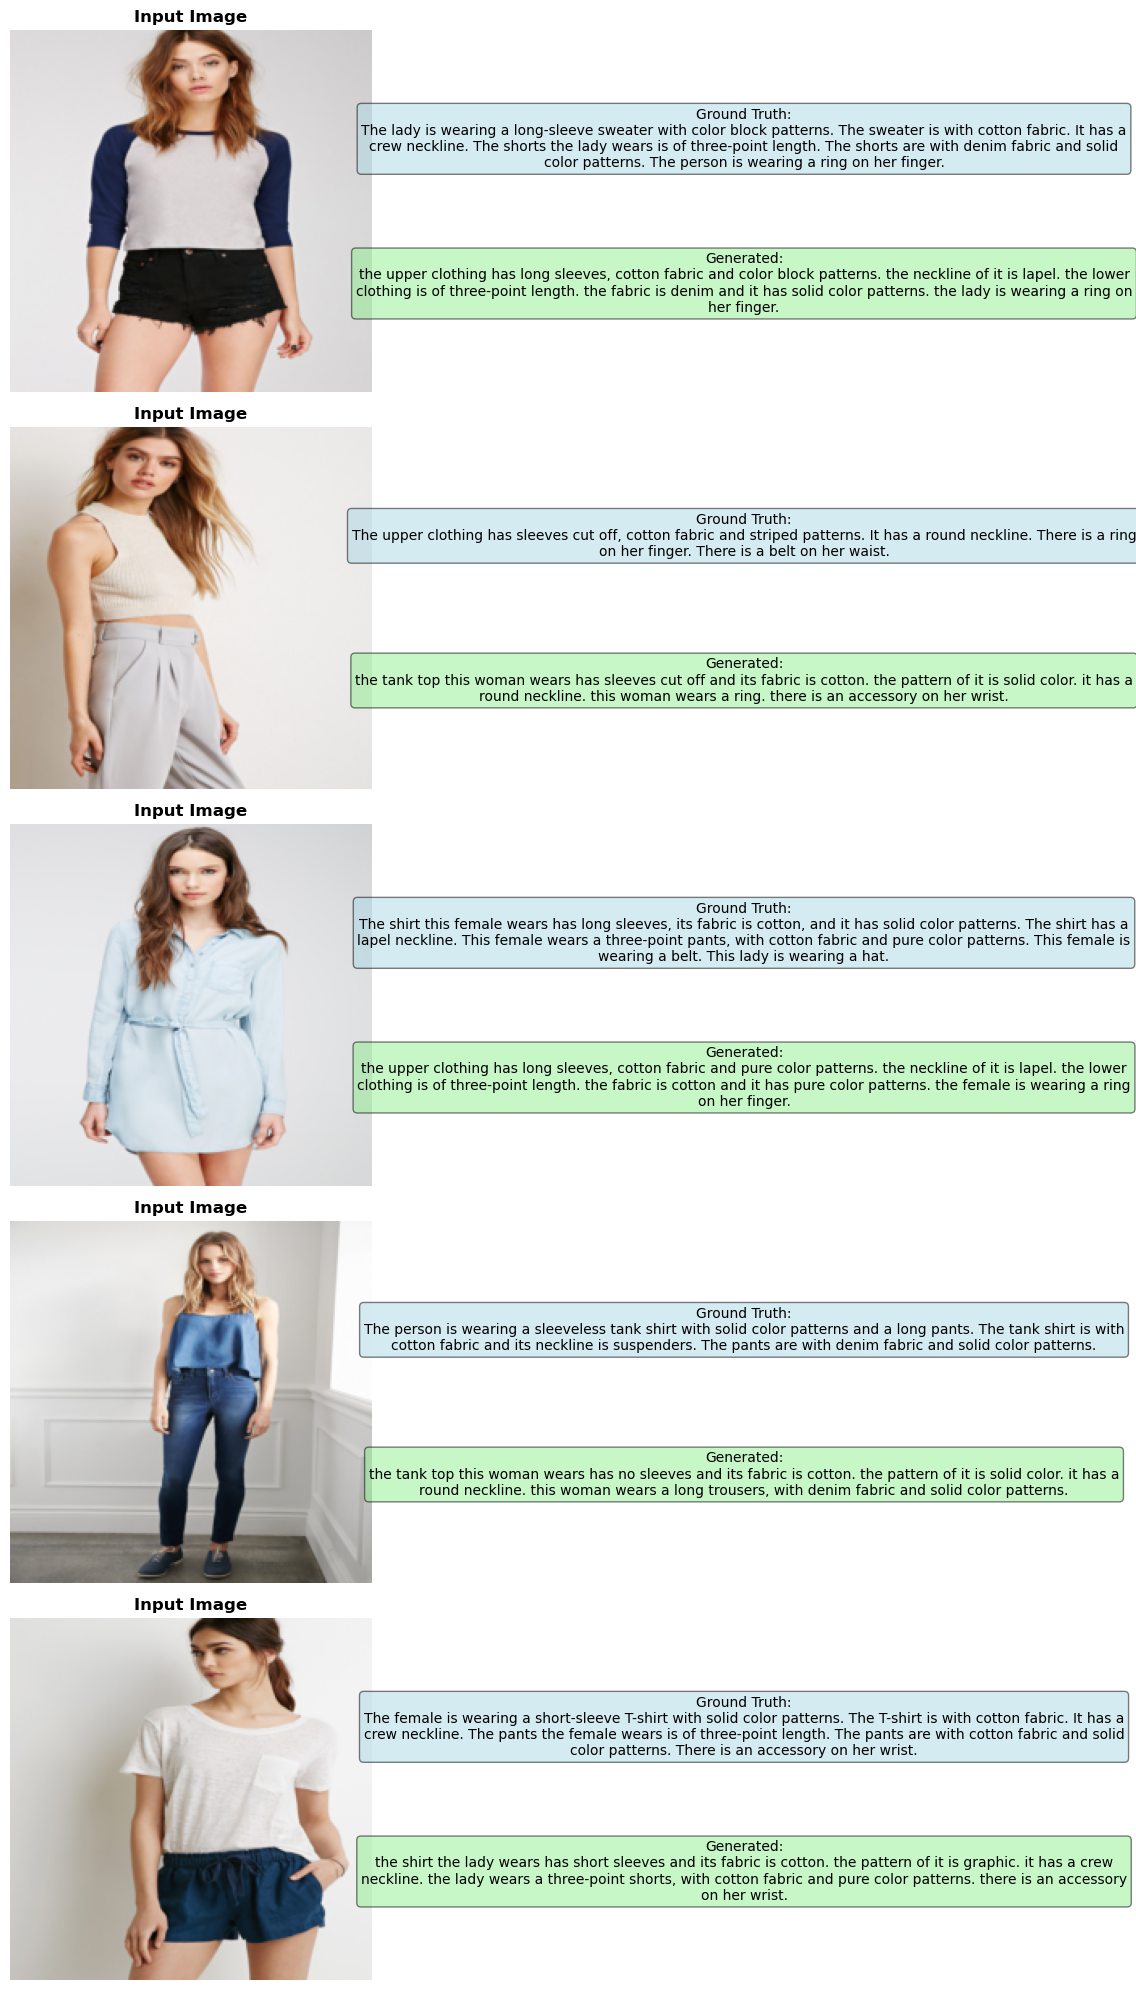

💾 Results saved to 'sample_results_raw_images.png'

✅ Testing complete! Model successfully generates captions from raw images.


In [110]:
# ============================================================================
# ALTERNATIVE TESTING METHOD: Using Raw Images (No pre-computed features)
# Use this if you don't have resnet_features_full_dataset.pth
# ============================================================================

# Load best model
checkpoint = torch.load('best_model.pth', map_location=device)
decoder.load_state_dict(checkpoint['decoder_state_dict'])
print("✅ Best model loaded!")

# Image transformation for testing (same as validation)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Test on random validation samples
print("\n🔍 Generating captions from raw images...\n")

num_samples = 5
sample_indices = random.sample(range(len(val_df)), num_samples)

fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))

for i, idx in enumerate(sample_indices):
    # Load image from disk
    img_path = os.path.join(image_dir, val_df.iloc[idx]['path'])
    ground_truth = val_df.iloc[idx]['caption']
    
    try:
        # Load and transform image for model
        image = Image.open(img_path).convert('RGB')
        image_tensor = transform_test(image).unsqueeze(0)  # Add batch dimension
        
        # Load image for display (no normalization)
        image_display = Image.open(img_path).convert('RGB')
        image_display = transforms.Resize((224, 224))(image_display)
        image_np = np.array(image_display) / 255.0
        
        # Generate caption using encoder + decoder
        # Pass the encoder (not None) and raw image
        generated_caption, alphas = generate_caption(
            encoder, decoder, image_tensor, vocab, device
        )
        
    except Exception as e:
        print(f"⚠️ Error loading image {img_path}: {e}")
        image_np = np.zeros((224, 224, 3))
        generated_caption = "[Error loading image]"
    
    # Display original image
    axes[i, 0].imshow(image_np)
    axes[i, 0].set_title('Input Image', fontsize=12, fontweight='bold')
    axes[i, 0].axis('off')
    
    # Display captions
    axes[i, 1].text(0.5, 0.7, f"Ground Truth:\n{ground_truth}", 
                    ha='center', va='center', fontsize=10, wrap=True,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    axes[i, 1].text(0.5, 0.3, f"Generated:\n{generated_caption}", 
                    ha='center', va='center', fontsize=10, wrap=True,
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    axes[i, 1].set_xlim(0, 1)
    axes[i, 1].set_ylim(0, 1)
    axes[i, 1].axis('off')
    
    print(f"Sample {i+1}:")
    print(f"  Image: {val_df.iloc[idx]['path']}")
    print(f"  Ground Truth: {ground_truth}")
    print(f"  Generated:    {generated_caption}")
    print()

plt.tight_layout()
plt.savefig('sample_results_raw_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Results saved to 'sample_results_raw_images.png'")
print("\n✅ Testing complete! Model successfully generates captions from raw images.")

## 12. Visualize Attention Weights

Visualizing attention mechanism...

Generated Caption: the female wears a long-sleeve shirt with pure color patterns and a three-point shorts. the shirt is with cotton fabric. the neckline of the shirt is round. the shorts are with cotton fabric and pure color patterns. the outer clothing is with cotton fabric and pure color patterns. there is
Ground Truth: The female wears a long-sleeve sweater with solid color patterns and a three-point pants. The sweater is with knitting fabric and its neckline is suspenders. The pants are with denim fabric and pure color patterns. This female also wears an outer clothing, with chiffon fabric and graphic patterns. The person is wearing a ring on her finger. There is an accessory in his her neck.


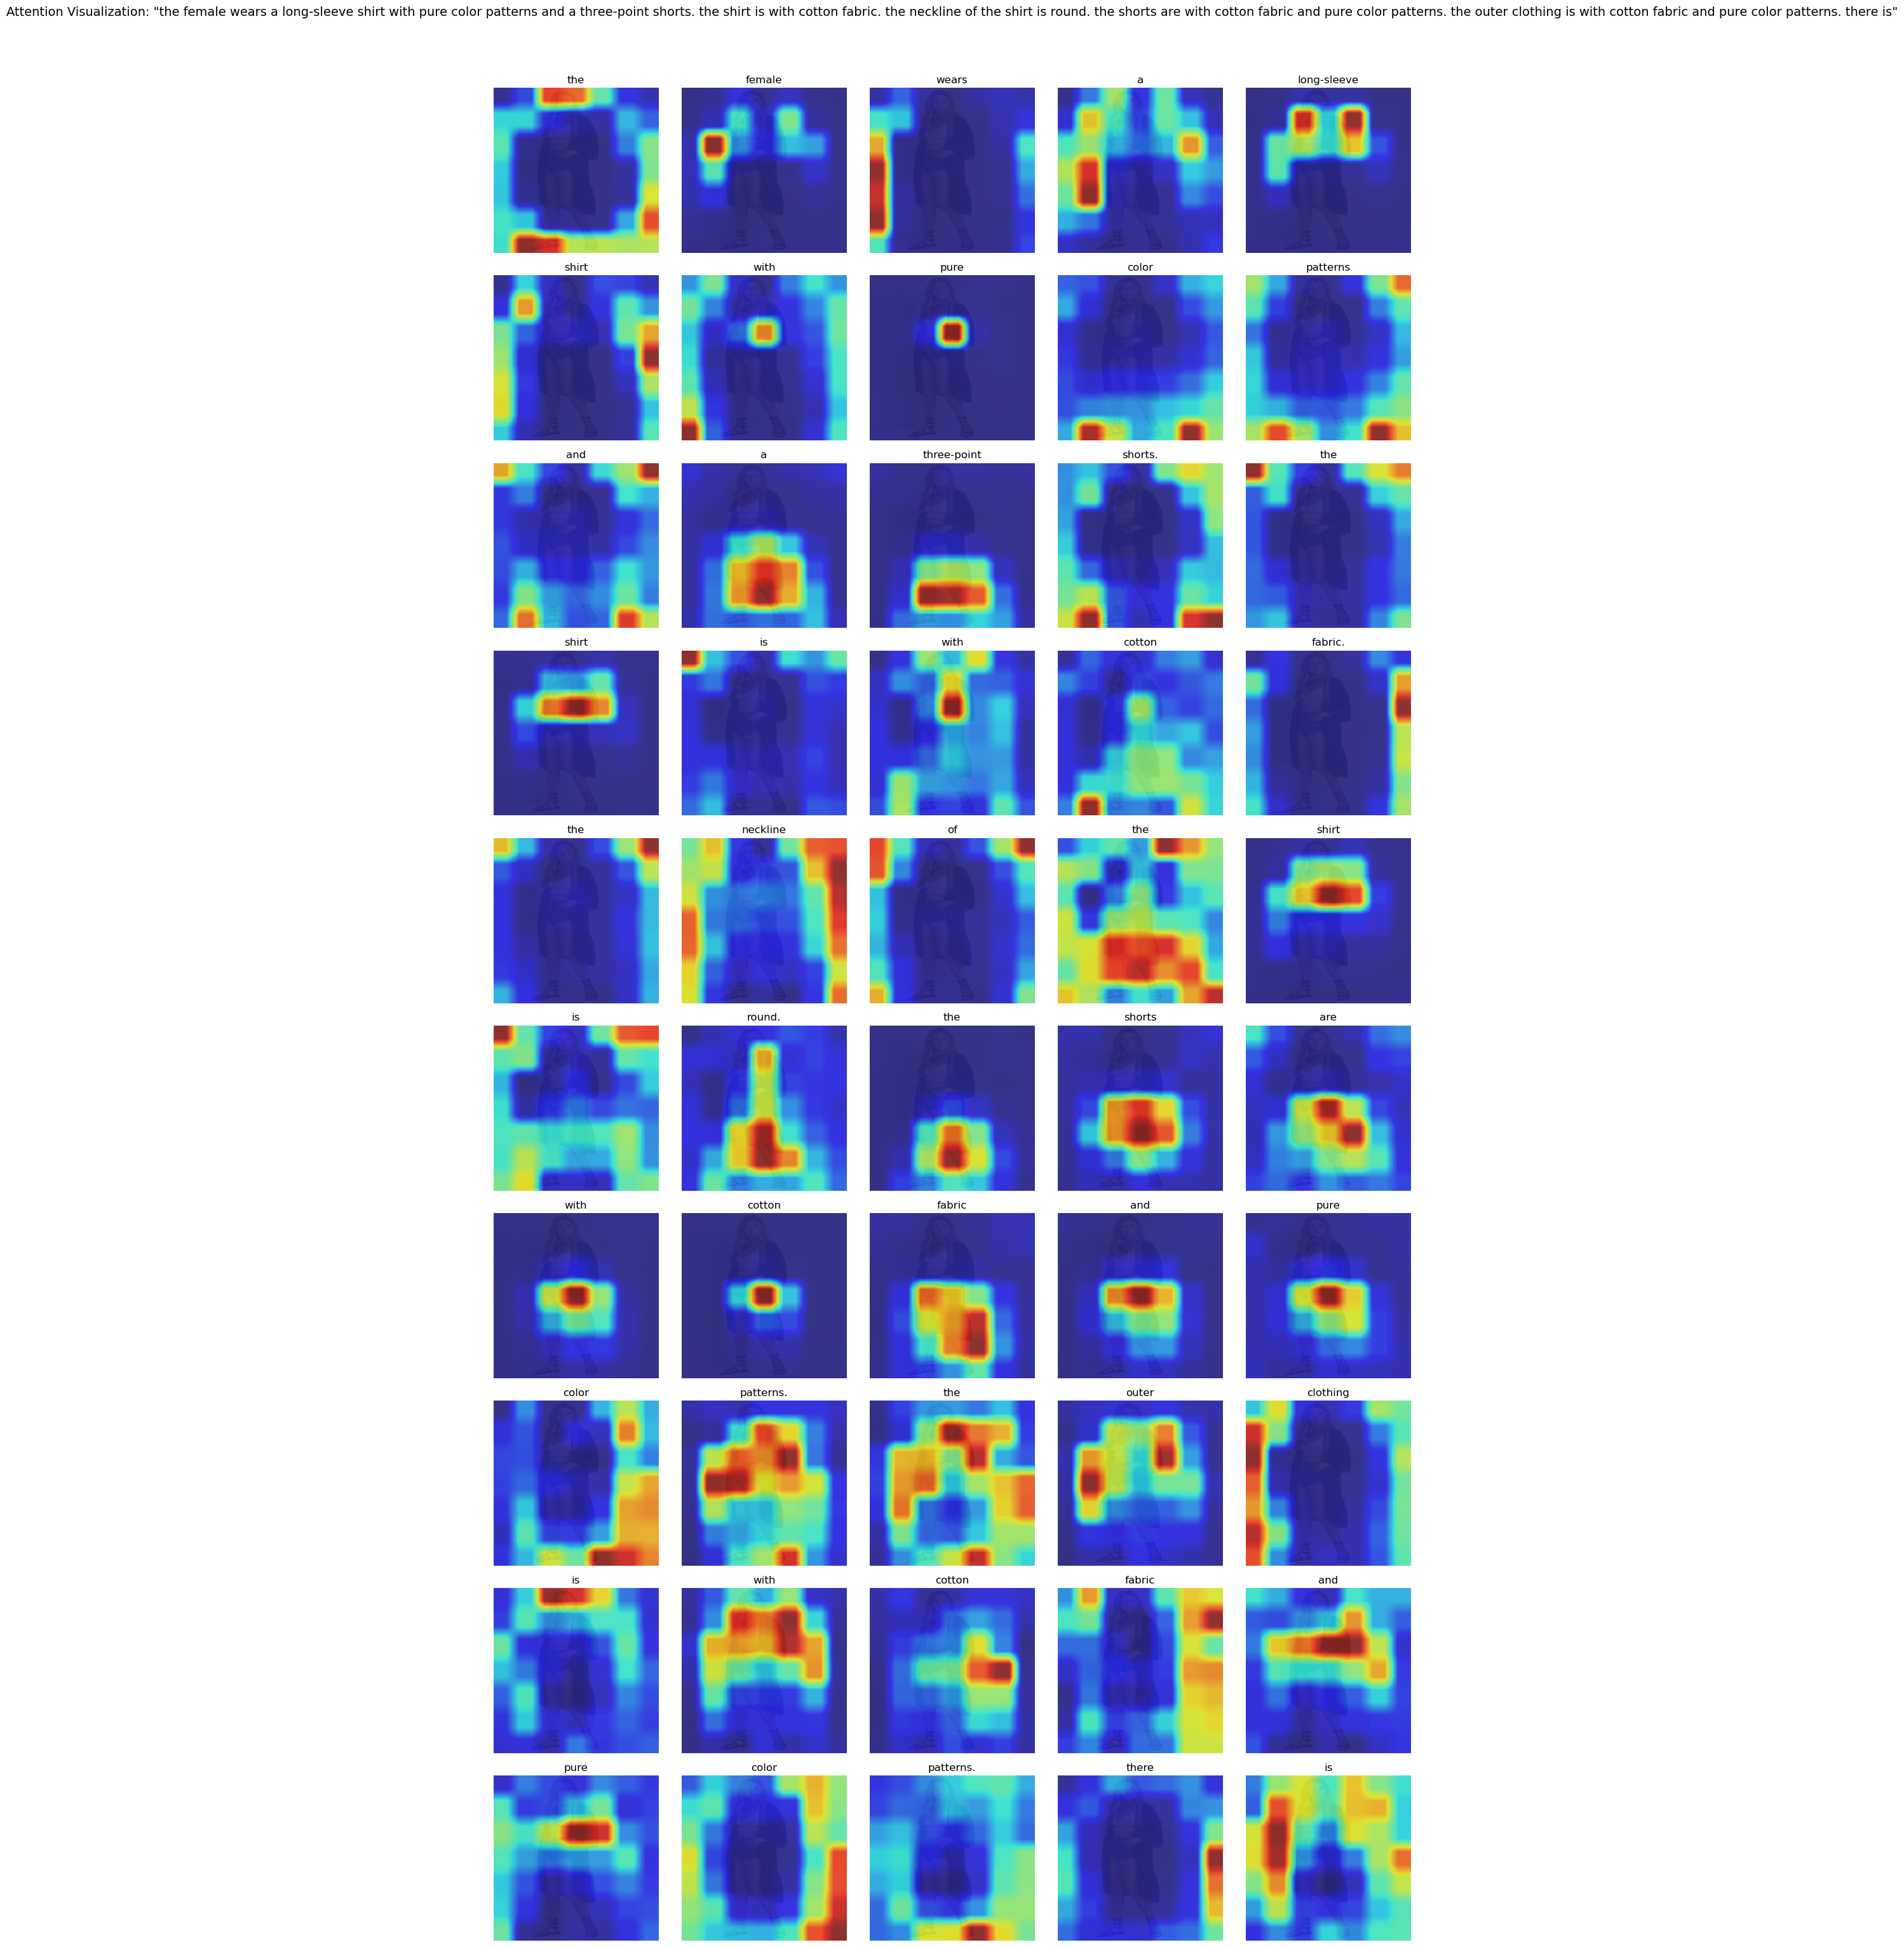

In [18]:
# Visualize attention for one sample
print("Visualizing attention mechanism...\n")

sample_idx = random.choice(range(len(val_dataset)))
feature, caption_encoded, length = val_dataset[sample_idx]

# Load the actual image for visualization (features are for model, image is for display)
img_path = os.path.join(image_dir, val_df.iloc[sample_idx]['path'])
from PIL import Image as PILImage
raw_image = PILImage.open(img_path).convert('RGB')

# Transform for display
transform_display = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
image_for_display = transform_display(raw_image)

# Generate caption with attention using pre-computed features
feature_input = feature.unsqueeze(0)
generated_caption, alphas = generate_caption(
    encoder, decoder, feature_input, vocab, device
)

print(f"Generated Caption: {generated_caption}")
print(f"Ground Truth: {val_df.iloc[sample_idx]['caption']}")

# Visualize attention using the RAW IMAGE (not features)
if alphas is not None:
    visualize_attention(image_for_display, generated_caption, alphas, vocab)

## 13. Evaluation Metrics (BLEU Score)

In [19]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

def evaluate_bleu(encoder, decoder, dataloader, vocab, device, num_samples=None):
    """
    Evaluate model using BLEU score.
    
    Args:
        encoder: encoder model
        decoder: decoder model
        dataloader: dataloader to evaluate on
        vocab: Vocabulary object
        device: device to use
        num_samples: number of samples to evaluate (None for all)
    Returns:
        avg_bleu: average BLEU score
    """
    encoder.eval()
    decoder.eval()
    
    references = []
    hypotheses = []
    
    smooth = SmoothingFunction()
    
    # Calculate total samples for progress bar
    total_samples = num_samples if num_samples else len(dataloader.dataset)
    
    count = 0
    with torch.no_grad():
        pbar = tqdm(total=total_samples, desc="Evaluating BLEU")
        for images, captions, lengths in dataloader:
            batch_size = images.size(0)
            
            for i in range(batch_size):
                # Generate caption
                image = images[i].unsqueeze(0)
                generated_caption, _ = generate_caption(
                    encoder, decoder, image, vocab, device
                )
                
                # Get reference caption
                caption_indices = captions[i].tolist()
                reference_caption = vocab.decode(caption_indices, skip_special_tokens=True)
                
                # Store for BLEU calculation
                references.append([reference_caption.split()])
                hypotheses.append(generated_caption.split())
                
                count += 1
                pbar.update(1)
                if num_samples and count >= num_samples:
                    break
            
            if num_samples and count >= num_samples:
                break
        pbar.close()
    
    # Calculate BLEU scores
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), 
                        smoothing_function=smooth.method1)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), 
                        smoothing_function=smooth.method1)
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), 
                        smoothing_function=smooth.method1)
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), 
                        smoothing_function=smooth.method1)
    
    print(f"\nBLEU Scores (evaluated on {count} samples):")
    print(f"  BLEU-1: {bleu1:.4f}")
    print(f"  BLEU-2: {bleu2:.4f}")
    print(f"  BLEU-3: {bleu3:.4f}")
    print(f"  BLEU-4: {bleu4:.4f}")
    
    return bleu1, bleu2, bleu3, bleu4

# Evaluate on ALL validation data for accurate scores
# print("Evaluating model performance on ALL validation samples...\n")
# bleu_scores = evaluate_bleu(encoder, decoder, val_loader, vocab, device, num_samples=None)
print(bleu_scores)

Evaluating model performance on ALL validation samples...



Evaluating BLEU:   0%|          | 0/1842 [00:00<?, ?it/s]


BLEU Scores (evaluated on 1842 samples):
  BLEU-1: 0.5704
  BLEU-2: 0.4484
  BLEU-3: 0.3725
  BLEU-4: 0.3083


## 14. Model Summary and Architecture Visualization

In [20]:
print("="*70)
print("MODEL ARCHITECTURE SUMMARY")
print("="*70)

print("\n1. ENCODER (ResNet-50)")
print("-" * 70)
print(f"   Architecture: Pretrained ResNet-50 (ImageNet)")
print(f"   Output: Spatial feature map (14 x 14 x 2048)")
print(f"   Total Parameters: {sum(p.numel() for p in encoder.parameters()):,}")
print(f"   Trainable: No (Frozen)")

print("\n2. ATTENTION MECHANISM")
print("-" * 70)
print(f"   Type: Soft Attention (Bahdanau-style)")
print(f"   Attention Dimension: {ATTENTION_DIM}")
print(f"   Input: Encoder features (196 pixels) + Decoder hidden state")
print(f"   Output: Context vector (weighted sum of encoder features)")
print(f"   Total Parameters: {sum(p.numel() for p in decoder.attention.parameters()):,}")

print("\n3. DECODER (LSTM with Attention)")
print("-" * 70)
print(f"   Embedding Dimension: {EMBED_DIM}")
print(f"   LSTM Hidden Dimension: {DECODER_DIM}")
print(f"   Vocabulary Size: {len(vocab)}")
print(f"   Total Parameters: {sum(p.numel() for p in decoder.parameters()):,}")
print(f"   Dropout: 0.5")

print("\n4. TRAINING CONFIGURATION")
print("-" * 70)
print(f"   Loss Function: Cross-Entropy + Attention Regularization")
print(f"   Optimizer: Adam")
print(f"   Decoder LR: {DECODER_LR}")
print(f"   Batch Size: {batch_size}")
print(f"   Max Epochs: {NUM_EPOCHS}")
print(f"   LR Scheduler: StepLR (step_size=5, gamma=0.8)")

print("\n5. DATASET STATISTICS")
print("-" * 70)
print(f"   Total Samples: {len(df):,}")
print(f"   Training Samples: {len(train_df):,}")
print(f"   Validation Samples: {len(val_df):,}")
print(f"   Average Caption Length: {df['caption_length'].mean():.1f} words")
print(f"   Max Caption Length: {df['caption_length'].max():.0f} words")

print("\n" + "="*70)
print("END OF SUMMARY")
print("="*70)

MODEL ARCHITECTURE SUMMARY

1. ENCODER (ResNet-50)
----------------------------------------------------------------------
   Architecture: Pretrained ResNet-50 (ImageNet)
   Output: Spatial feature map (14 x 14 x 2048)
   Total Parameters: 23,508,032
   Trainable: No (Frozen)

2. ATTENTION MECHANISM
----------------------------------------------------------------------
   Type: Soft Attention (Bahdanau-style)
   Attention Dimension: 512
   Input: Encoder features (196 pixels) + Decoder hidden state
   Output: Context vector (weighted sum of encoder features)
   Total Parameters: 1,312,257

3. DECODER (LSTM with Attention)
----------------------------------------------------------------------
   Embedding Dimension: 512
   LSTM Hidden Dimension: 512
   Vocabulary Size: 150
   Total Parameters: 10,910,359
   Dropout: 0.5

4. TRAINING CONFIGURATION
----------------------------------------------------------------------
   Loss Function: Cross-Entropy + Attention Regularization
   Optimizer